In [1]:
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt

import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import mean_absolute_error


ratings = pd.read_csv('ml-latest-small/ratings.csv')
movies = pd.read_csv('ml-latest-small/movies.csv')
#print(movies.head())

ratings = pd.merge(ratings, movies, left_on='movieId', right_on='movieId')

ratings = ratings.drop('genres', 1)


ratings.userId = ratings.userId.astype('category').cat.codes.values
ratings.movieId = ratings.movieId.astype('category').cat.codes.values

print(ratings.head())

Using TensorFlow backend.


   userId  movieId  rating   timestamp             title
0       0        0     4.0   964982703  Toy Story (1995)
1       4        0     4.0   847434962  Toy Story (1995)
2       6        0     4.5  1106635946  Toy Story (1995)
3      14        0     2.5  1510577970  Toy Story (1995)
4      16        0     4.5  1305696483  Toy Story (1995)


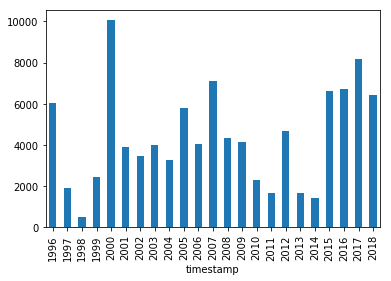

In [2]:
#Convert timestamps to dates
ratings['timestamp'] = ratings['timestamp'].apply(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d'))
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'])

#plot timestamps frequencies
ratings["timestamp"].groupby(ratings["timestamp"].dt.year).count().plot(kind="bar",)

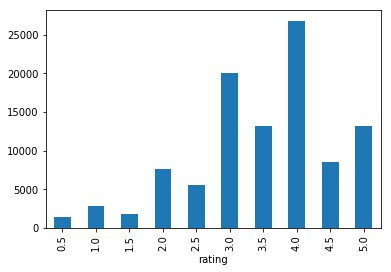

In [3]:
# Plot ratings frequencies
ratings['rating'].groupby(ratings['rating']).count().plot(kind='bar')

In [4]:
#train = ratings[(ratings['timestamp'] < '2017-07-01') ]
#test = ratings[(ratings['timestamp'] >= '2017-07-01') ]

ratings = ratings.drop('timestamp', 1)

In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(ratings, test_size=0.05)

In [6]:
print("Number of rows in test data set:", (len(test)))
print("Number of rows in training data set:",(len(train)))
n_users, n_movies = len(ratings['userId'].unique()), len(ratings['movieId'].unique())

print("Number of users:",n_users)
print("Number of movies:",n_movies)

Number of rows in test data set: 5042
Number of rows in training data set: 95794
Number of users: 610
Number of movies: 9724


# Embedding only

In [7]:
n_latent_factors = 3
movie_input = keras.layers.Input(shape=[1],name='Movie')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input))

prod = keras.layers.dot([movie_vec, user_vec],axes=-1)

model = keras.Model([user_input, movie_input], prod)
model.compile(optimizer=Adam(),loss= 'mean_absolute_error')


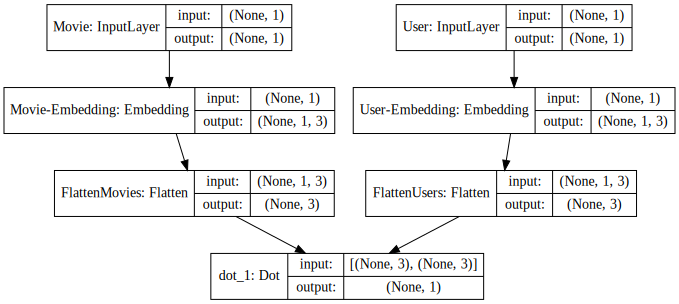

In [8]:
#visualize model
SVG(model_to_dot(model,show_shapes=True, rankdir='HB').create(prog='dot', format='svg'))

Text(0, 0.5, 'Train Error')

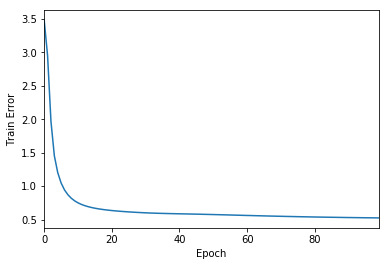

In [9]:
history = model.fit([train['userId'], train['movieId']], train.rating,batch_size=128, epochs=100, verbose=0)
pd.Series(history.history['loss']).plot()
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In [10]:
y_hat = model.predict([test.userId, test.movieId])
y_true = test.rating

mean_absolute_error(y_true,y_hat)

0.769539007194311

# Embedding & Neural Network

In [11]:
n_latent_factors_user = 5
n_latent_factors_movie = 8

movie_input = keras.layers.Input(shape=[1],name='Movie')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
movie_vec = keras.layers.Dropout(0.5)(movie_vec)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding')(user_input))
user_vec = keras.layers.Dropout(0.5)(user_vec)


concat = keras.layers.concatenate([movie_vec, user_vec])
concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(200,name='FullyConnected')(concat)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
dense_2 = keras.layers.Dense(100,name='FullyConnected-1')(concat)
dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2')(dense_2)
dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)


result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
model = keras.Model([user_input, movie_input], result)
model.compile(optimizer=Adam(lr=0.001),loss= 'mean_absolute_error')


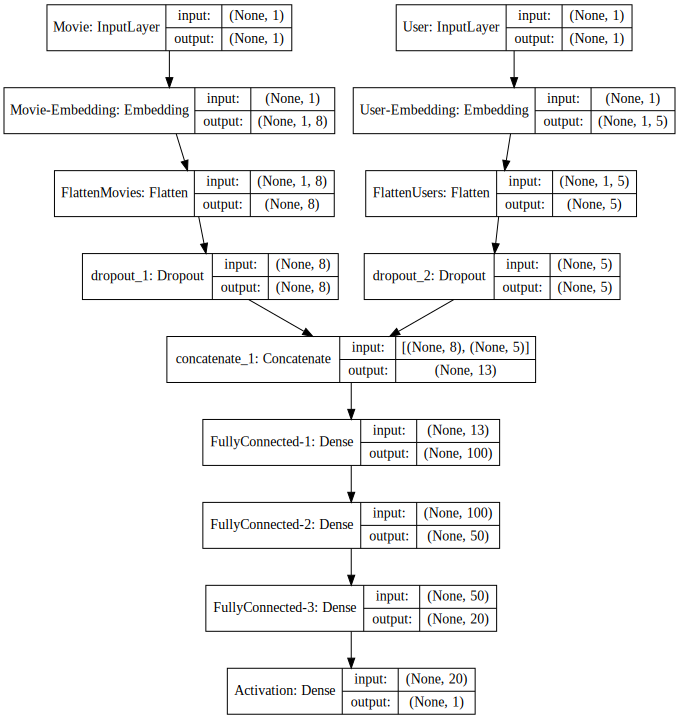

In [12]:
#visualize model
SVG(model_to_dot(model,  show_shapes=True, rankdir='HB').create(prog='dot', format='svg'))

Text(0, 0.5, 'Train Error')

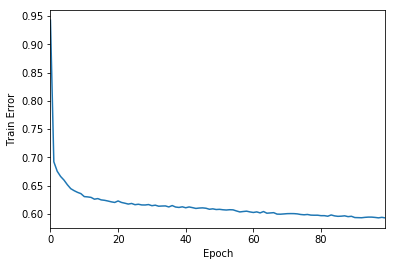

In [13]:
history = model.fit([train['userId'], train['movieId']], train.rating,batch_size=256, epochs=100, verbose=0)
pd.Series(history.history['loss']).plot()
plt.xlabel("Epoch")
plt.ylabel("Train Error")


In [14]:
y_hat = model.predict([test.userId, test.movieId])
y_true = test.rating

mean_absolute_error(y_true, y_hat)

0.6498807130801871